In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import netCDF4
import sys
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.interpolate import griddata
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
# sys.path.append("scripts")
%matplotlib inline

In [3]:
class acb_data:

    def __init__(self, path):
        nc = xr.open_dataset(path)
        self.name = nc.id
        idx = np.where(nc['oxy'][:]>0)
        self.lat = nc['latitude'][idx]
        self.lon = nc['longitude'][idx]
        self.depth = nc['dep'][idx]
        self.salt = nc['salt'][idx]
        self.temp = nc['temp'][idx]
        self.dens = nc['dens'][idx]
        self.ox = nc['oxy'][idx]
        self.cdom = nc['cdom'][idx]
        self.turb = nc['turb'][idx]
        self.fluor = nc['fluor'][idx]
        try:
            self.btm = nc['bottom'][idx] + 1.
        except:
            pass
        self.distance = self.calc_distance()
        self.date = nc['header'].date
        nc.close()

    def calc_distance(self, r=6367.):
        lat = np.radians(self.lat)
        lon = np.radians(self.lon)
        a = np.sin(np.diff(lat)/2.0)**2 + np.cos(lat[:-1]) * np.cos(lat[1:]) * np.sin(np.diff(lon)/2.0)**2
        pair_dist = r * 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
        distance = np.insert(np.cumsum(pair_dist),0, 0.)
        if ((self.lat[0]<self.lat[-1]) and ('_L' in self.name)) or (self.lon[0]>self.lon[-1] and ('_A' in self.name)):
            distance = distance[::-1]            
        return distance


    def make_plot(self, key, 
                  pick=None, dx=0,
                  fig=None, ax=None, 
                  cmap=None, vmin=None, vmax=None, colorbar=True, 
                  lbls = ['on', 'on', 'on', 'on']):
        '''make_plot(key, pick=None, fig=None, ax=None)'''
        costume = {'oxy': (self.ox, cmocean.cm.oxy, r'DO [$ml/L$]', 0, 12),
                   'temp': (self.temp, cmocean.cm.thermal, r'Temp [$^\circ$C]', 18, 35),
                   'salt': (self.salt, cmocean.cm.haline, r'Salinity [PSS]', 10, 40),
                   'dens': (self.dens, cmocean.cm.dense, r' Density [$kg/m^2$]', 1010, 1026),
                   'cdom': (self.cdom, cmocean.cm.matter, r' CDOM [$mg/m^3$]', 0, 32),
                   'turb': (self.turb, cmocean.cm.turbid, r' Turbidity [NTU]', 0, 5),
                   'fluor': (self.fluor, cmocean.cm.algae, r' Chl-a [$mg/m^3$]', 0, 8)
                   }
        
        if pick==None:
            idx = range(costume[key][0].size)
        else:
            if pick=='up': 
                idx = np.where(np.diff(self.depth)>0)[0]
            elif pick=='down': 
                idx = np.where(np.diff(self.depth)<0)[0]
            else:
                return 'Choose "up" or "down"'
        self.idx = idx
        if fig==ax==None:
            fig, ax = plt.subplots(figsize=(15,8))
        if cmap==None:
            cmap=costume[key][1]
        if vmin==None:
            vmin=costume[key][3]
        if vmax==None:
            vmax=costume[key][4]            

        mappable = ax.scatter(self.distance[idx], self.depth[idx], c=costume[key][0][idx], s=45, 
                              cmap=cmap, vmin=vmin, vmax=vmax, edgecolors="None")

        if lbls[1] is True:
            ax2 = ax.twiny()
            if '_L' in self.name:
                ax2.set_xlabel(r'Latitude ($\degree$N)', size=8)
                ax2.set_xlim(self.lat[idx].min(), self.lat[idx].max())
            elif '_A' in self.name:
                ax2.set_xlabel(r'Longitude ($\degree$W)', size=8)
                ax2.set_xlim(self.lon[idx].min(), self.lon[idx].max())
            ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax2.xaxis.set_tick_params(labelsize='small')
            ax2.xaxis.set_major_locator(MultipleLocator(base=.1))
            
            
        try:
            ax.scatter(self.distance[idx], self.btm[idx], s=.5, color='k')
        except:
            pass
        ax.tick_params(direction='out', 
                       labelleft=lbls[0], labelright=lbls[2], labelbottom=lbls[3])
        ax.set_ylim(self.depth.max(), 0)
    
        if colorbar is True:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="2%")
            cb = plt.colorbar(mappable, cax=cax)
            cb.set_label(costume[key][2], color='0.2')

            return fig, ax, cb
        
        else:
            return mappable

In [4]:
def background(ax, extent=[-95, -91, 27.99, 30.01], p=ccrs.PlateCarree(), res='10m', 
               mers=np.arange(-98, -86), pars=[28, 29, 30],):
    ax.set_extent(extent)
    ax.coastlines(resolution=res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land',
                                                scale=res, facecolor='slategrey'))
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',
                                                scale=res, edgecolor='blue', facecolor='none'))
    if ('PlateCarree' or 'Mercator') in str(p):
        lab = True
    else:
        lab = False
    gl = ax.gridlines(xlocs=mers, ylocs=pars, draw_labels=lab,
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'rotation':-90}
    return gl

In [12]:
test = acb_data('../acrobat/MS01_A10.nc')
test.distance

<xarray.DataArray 'latitude' (dimz: 104156)>
array([72.76663554, 72.76663554, 72.76663554, ...,  0.        ,
        0.        ,  0.        ])
Dimensions without coordinates: dimz

In [13]:
test = acb_data('../acrobat/MS01_A13_b.nc')
test.distance

<xarray.DataArray 'latitude' (dimz: 48697)>
array([42.0309308, 42.0309308, 42.0309308, ...,  0.       ,  0.       ,
        0.       ])
Dimensions without coordinates: dimz

/opt/miniconda3/envs/pong/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


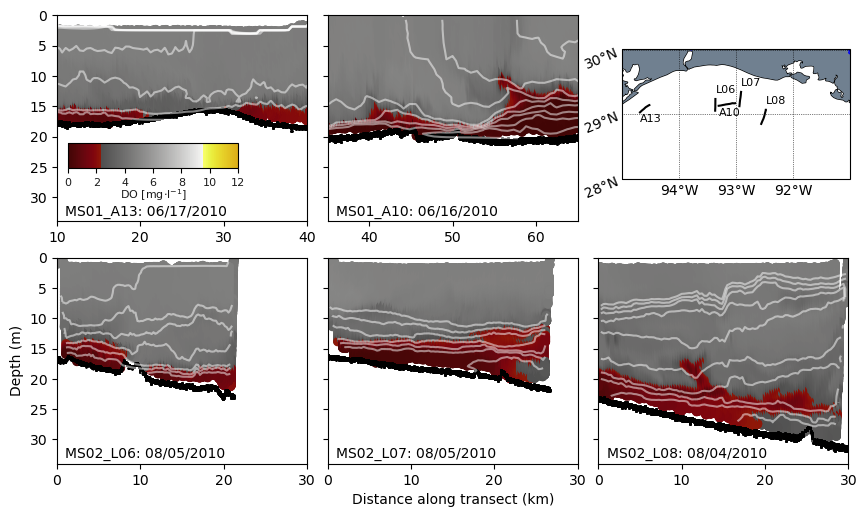

In [17]:
dxs = [10, 35, 0, 0, 0, 0]
files = ['MS01_A13_b', 'MS01_A10', 'MS01_L09', 'MS02_L06', 'MS02_L07', 'MS02_L08', 'MS07_L09'] #'MS02_L07',

fig, axes = plt.subplots(2, 3, figsize=(8.5, 5), dpi=100)
pos = axes[0,2].get_position()
axm = fig.add_axes([pos.x0+.05, pos.y0+0.08, pos.width+.04, pos.height], projection=ccrs.PlateCarree())
axm.set_aspect(1.13)
background(axm)
for i, ax in enumerate(axes.flatten()):
    bottom = True
    left = False
    if i==2:
        ax.axis('off')
    else:
        if i in [3, 4, 5]:
            bottom =  True
            if i==4:
                ax.set_xlabel('Distance along transect (km)')
        if i in [0,3]:
            left = True
            if i==3:
                ax.set_ylabel('Depth (m)')
        line = acb_data('../acrobat/'+files[i]+'.nc')
        dist, depth = np.meshgrid(np.linspace(0,line.distance.max(),100),np.linspace(0,line.depth.max(),30))
        idx = np.where(np.diff(line.depth)>0)[0]
        dens = griddata((line.distance[idx], line.depth[idx]),line.dens[idx],(dist, depth),method='linear')
        lbls = [left, False, False, bottom]
        mp = line.make_plot('oxy', 'up', lbls=lbls, colorbar=False, ax=ax)
        ax.contour(dist, depth, dens, np.linspace(1015,1030, 16), colors='w', alpha=0.5)
        msk = np.ma.where((line.distance > dxs[i]) & (line.distance < dxs[i]+30.))
        axm.plot(line.lon[msk], line.lat[msk], 'k', transform=ccrs.PlateCarree())
        if 'A' in line.name:
            axm.text(line.lon[msk].min(), line.lat[msk].min()-0.15, line.name[-3:], size=8)
        elif 'L' in line.name:
            axm.text(line.lon[msk].max(), line.lat[msk].max()+0.1, line.name[-3:], size=8)
        ax.text(1+dxs[i], 33, line.name+': '+line.date)
        ax.set_xlim(dxs[i], dxs[i]+30.)
        ax.set_ylim(34, 0)
cax = fig.add_axes([.07, .68, .2, .05])
cb = fig.colorbar(mp, cax=cax, orientation='horizontal', ticks = np.linspace(0,12, 2))
cb.set_label(r'DO [mg$\cdot$l$^{-1}$]', labelpad=-1, fontsize=8, color='0.1')
cb.ax.tick_params(labelsize=8, labelcolor='0.1')
cb.set_ticks(np.linspace(0,12,7))

fig.tight_layout(pad=.1, h_pad=.5, w_pad=.5)
fig.savefig('figures/acrobat.png')